<a href="https://colab.research.google.com/github/HazemmoAlsady/AWN_Graduation_Project/blob/main/Hazem's%20edits/Final_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
import joblib


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
df = pd.read_excel('/content/drive/MyDrive/cleaned_awn_data.xlsx')

df = df[df["need_level"] != "Unknown"].reset_index(drop=True)


In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier


In [107]:
need_features = [
    "family_size",
    "income_monthly",
    "monthly_expenses",
    "debts",
    "number_of_children",
    "age",
    "expense_to_income_ratio",
    "case_type",
    "housing_type",
    "health_status",
    "city",
    "gender"
]

X = df[need_features]
y = df["need_level"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [108]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

need_preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])


In [109]:
need_level_model = Pipeline(steps=[
    ("preprocess", need_preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])


In [110]:
need_level_encoder = LabelEncoder()
y_train_enc = need_level_encoder.fit_transform(y_train)


In [111]:
need_level_model.fit(X_train, y_train_enc)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['family_size', 'income_monthly', 'monthly_expenses', 'debts',
       'number_of_children', 'age', 'expense_to_income_ratio'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['case_type', 'housing_type', 'health_status', 'city', 'gender'], dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=10, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

Accuracy: 0.9258540372670807
              precision    recall  f1-score   support

        High       0.93      0.91      0.92      2821
         Low       0.90      0.93      0.92      2014
      Medium       0.93      0.93      0.93      5469

    accuracy                           0.93     10304
   macro avg       0.92      0.93      0.92     10304
weighted avg       0.93      0.93      0.93     10304



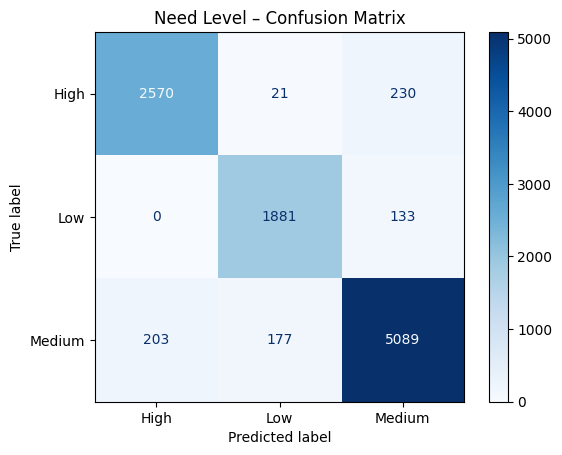

In [112]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

y_pred = need_level_model.predict(X_test)
y_pred = need_level_encoder.inverse_transform(y_pred)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap="Blues"
)
plt.title("Need Level – Confusion Matrix")
plt.show()


In [113]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Encode y_test
y_test_enc = need_level_encoder.transform(y_test)

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        class_weight="balanced",
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", need_preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train_enc)
    preds = pipe.predict(X_test)

    acc = accuracy_score(y_test_enc, preds)
    results.append((name, acc))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
results_df


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy
0,Logistic Regression,0.819488
1,Random Forest,0.930318
2,XGBoost,0.947108


In [114]:
rf = need_level_model.named_steps["model"]

importances = rf.feature_importances_

pd.DataFrame({
    "feature": num_cols.tolist() +
               list(need_level_model.named_steps[
                   "preprocess"
               ].transformers_[1][1]
               .named_steps["onehot"]
               .get_feature_names_out(cat_cols)),
    "importance": importances
}).sort_values("importance", ascending=False)


,feature,importance
3,debts,0.386402
2,monthly_expenses,0.237178
6,expense_to_income_ratio,0.223431
1,income_monthly,0.080081
5,age,0.014378
4,number_of_children,0.008171
0,family_size,0.007272
29,city_القاهرة,0.001899
18,housing_type_سكن لدى الأقارب,0.001876
26,city_0 الزقازيق\n1 سوهاج\...,0.001816


In [142]:
df2 = df.copy()
df2 = df2[
    (df2["assistance_type"] != "Unknown") &
    (df2["request_text"] != "Unknown")
].reset_index(drop=True)


In [143]:
import re

def clean_text(text):
    text = str(text)
    leakage_words = [
        "سلة", "غذائية", "طعام",
        "علاج", "أدوية", "عملية",
        "مدارس", "تعليم",
        "كرسي", "إعاقة",
        "مالية", "إيجار", "سكن"
    ]
    for w in leakage_words:
        text = re.sub(w, "", text)
    return re.sub(r"\s+", " ", text).strip()

df2["request_text_clean"] = df2["request_text"].apply(clean_text)


In [154]:
num_features = [
    "family_size", "income_monthly", "monthly_expenses",
    "debts", "number_of_children", "age",
    "expense_to_income_ratio"
]

cat_features = [
    "housing_type",
    "health_status",
    "city",
    "gender"
]
text_feature = "request_text_clean"

X = df2[num_features + cat_features + [text_feature]]
y = df2["assistance_type"]


In [155]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer

assist_preprocessor = ColumnTransformer([
    ("text", TfidfVectorizer(max_features=1500, ngram_range=(1,1), min_df=5), text_feature),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_features),
    ("num", SimpleImputer(strategy="median"), num_features)
])


In [163]:
("model", XGBClassifier(
    objective="multi:softprob",
    num_class=len(assistance_encoder.classes_),
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
))

('model',
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=400,
               n_jobs=None, num_class=6, ...))

In [164]:
assistance_encoder = LabelEncoder()
y_train_enc = assistance_encoder.fit_transform(y_train)


In [165]:
assistance_model.fit(X_train, y_train_enc)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=1500,
                                                                  min_df=5),
                                                  'request_text_clean'),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['housing_type',
                                                   'health_status', 'city',
                                                   'gender']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['family_size',
                                                   'income_monthly',
                                                   'monthly_expenses', 'debts',
                                                   'number_of_children', 'age',
                                                   'expense_to_income_ratio'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=22,
                                        min_samples_split=10, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

In [166]:
from sklearn.metrics import accuracy_score


models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=22,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        num_class=len(assistance_encoder.classes_),
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
}

from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():

    pipe = Pipeline([
        ("preprocess", assist_preprocessor),
        ("model", model)
    ])

    scores = cross_val_score(
        pipe,
        X,
        y_enc,
        cv=skf,
        scoring="accuracy",
        n_jobs=-1
    )

    results.append((name, np.mean(scores)))

pd.DataFrame(results, columns=["Model", "CV Accuracy"])

,Model,CV Accuracy
0,Random Forest,1.0
1,XGBoost,1.0


In [124]:
BASE_PATH = "/content/drive/MyDrive/graduation_project/final_model"
os.makedirs(BASE_PATH, exist_ok=True)

joblib.dump(need_level_model, f"{BASE_PATH}/need_level_model.joblib")
joblib.dump(need_level_encoder, f"{BASE_PATH}/need_level_encoder.joblib")

joblib.dump(assistance_model, f"{BASE_PATH}/assistance_model.joblib")
joblib.dump(assistance_encoder, f"{BASE_PATH}/assistance_encoder.joblib")


['/content/drive/MyDrive/graduation_project/final_model/assistance_encoder.joblib']

In [125]:
import pickle
import os

BASE_PATH = "/content/drive/MyDrive/graduation_project/final_model"
os.makedirs(BASE_PATH, exist_ok=True)

# Need Level Pipeline
with open(f"{BASE_PATH}/need_level_pipeline.pkl", "wb") as f:
    pickle.dump(need_level_model, f)

# Need Level Encoder
with open(f"{BASE_PATH}/need_level_encoder.pkl", "wb") as f:
    pickle.dump(need_level_encoder, f)
# Assistance Type Pipeline
with open(f"{BASE_PATH}/assistance_type_pipeline.pkl", "wb") as f:
    pickle.dump(assistance_model, f)

# Assistance Type Encoder
with open(f"{BASE_PATH}/assistance_type_encoder.pkl", "wb") as f:
    pickle.dump(assistance_encoder, f)


In [183]:
# الفيتشرز اللي هنستخدمها فقط
num_features = [
    "income_monthly",
    "debts",
    "expense_to_income_ratio",
    "family_size",
    "number_of_children",
    "age"
]

cat_features = [
    "health_status",
    "housing_type"
]

X_struct = df2[num_features + cat_features]
y = df2["assistance_type"]

In [184]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

In [185]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

In [186]:
from xgboost import XGBClassifier

model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=len(encoder.classes_),
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

In [187]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    model,
    X_struct,
    y_enc,
    cv=skf,
    scoring="accuracy",
    n_jobs=-1
)

print("Fold Scores:", scores)
print("Mean Accuracy:", np.mean(scores))

Fold Scores: [0.2533319  0.25013437 0.25056433 0.25346662 0.2495969 ]
Mean Accuracy: 0.2514188254992958


In [188]:
model.fit(X_struct, y_enc)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['income_monthly', 'debts',
                                                   'expense_to_income_ratio',
                                                   'family_size',
                                                   'number_of_children',
                                                   'age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['health_status',
                                                   'housing_type'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsa...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None, num_class=6, ...))])

In [190]:
sample = pd.DataFrame([{
    "income_monthly": 2500,
    "debts": 10000,
    "expense_to_income_ratio": 4000/2500,
    "family_size": 5,
    "number_of_children": 3,
    "age": 40,
    "health_status": "مريض ضغط",
    "housing_type": "إيجار"
}])

proba = model.predict_proba(sample)[0]

for cls, p in zip(encoder.classes_, proba):
    print(cls, round(p*100,2), "%")

disability_equipment 4.06 %
education 16.43 %
financial 18.96 %
food 20.56 %
housing 11.89 %
medical 28.09 %
